<a href="https://colab.research.google.com/github/rkh4m/CS4824_Capstone_Project/blob/main/Movie_Reviews.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")

DATA_PATH = "Train.csv/Train.csv"
train_df = pd.read_csv(DATA_PATH, encoding="utf-8-sig")

print(f"Train shape: {train_df.shape}")
train_df.head()

Train shape: (40000, 2)


,text,label
0,I grew up (b. 1965) watching and loving the Th...,0
1,"When I put this movie in my DVD player, and sa...",0
2,Why do people who do not know what a particula...,0
3,Even though I have great interest in Biblical ...,0
4,Im a die hard Dads Army fan and nothing will e...,1


## Training data overview
This section inspects the class balance, text lengths, and missing values in the movie review training split.

### Schema and missing values
Understand the column types and presence of nulls before modeling.

In [2]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    40000 non-null  object
 1   label   40000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 625.1+ KB


In [3]:
missing_summary = train_df.isnull().mean().mul(100).round(2)
missing_summary.to_frame(name="percent_missing")

,percent_missing
text,0.0
label,0.0


### Class distribution
Check whether the dataset is balanced across sentiment labels.

In [4]:
label_counts = train_df['label'].value_counts().sort_index()
label_counts

label
0    20019
1    19981
Name: count, dtype: int64

C:\Users\rukha\AppData\Local\Temp\ipykernel_10588\2581298822.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")


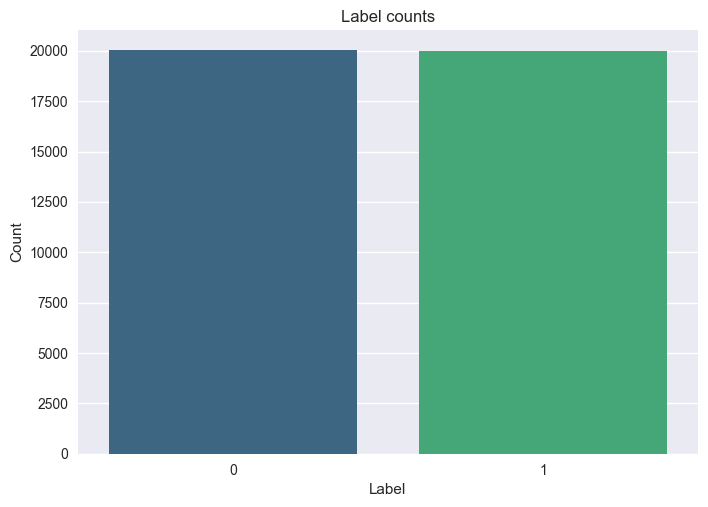

In [5]:
sns.barplot(x=label_counts.index, y=label_counts.values, palette="viridis")
plt.title("Label counts")
plt.xlabel("Label")
plt.ylabel("Count")
plt.show()

### Review length analysis
Assess how long the reviews are to guide tokenization choices.

In [6]:
train_df['char_len'] = train_df['text'].str.len()
train_df['word_len'] = train_df['text'].str.split().str.len()

length_summary = train_df[['char_len', 'word_len']].describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
length_summary

,char_len,word_len
count,40000.000000,40000.000000
mean,1310.293250,231.339250
std,988.358599,171.194123
min,32.000000,4.000000
10%,501.000000,90.000000
25%,698.000000,126.000000
50%,973.000000,173.000000
75%,1596.000000,282.000000
90%,2583.100000,452.000000
max,13704.000000,2470.000000


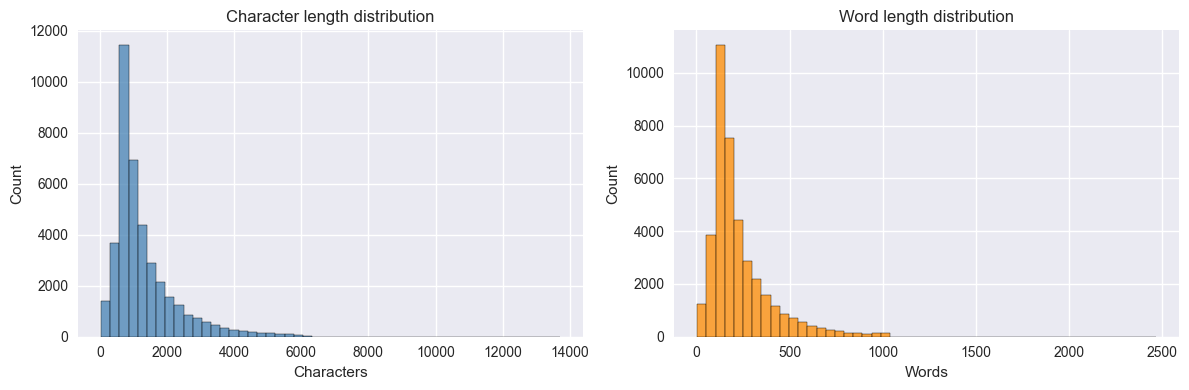

In [7]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.histplot(train_df['char_len'], bins=50, ax=axes[0], color="steelblue")
axes[0].set_title("Character length distribution")
axes[0].set_xlabel("Characters")

sns.histplot(train_df['word_len'], bins=50, ax=axes[1], color="darkorange")
axes[1].set_title("Word length distribution")
axes[1].set_xlabel("Words")

plt.tight_layout()
plt.show()

### Length by label
Compare how review length differs across sentiment classes.

In [8]:
length_by_label = train_df.groupby('label')[['char_len', 'word_len']].agg(['mean', 'median', 'max']).round(1)
length_by_label

char_len               word_len             
          mean median    max     mean median   max
label                                             
0       1292.5  973.0   8969    229.2  174.0  1522
1       1328.1  972.0  13704    233.5  173.0  2470